# $k$-armed bandits

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## The $k$-armed testbed

In order to demonstrate the bandit-algorithms, let us create some test-data. Here, we have five actions $a=1,...,5$ and their mean rewards are $q_*(a)=5, 4, 8, 3, 7$. The actual rewards are drawn from a normal distribution with mean $q_*(a)$ and variance 1.

In [36]:
from bandit import Bandit
testbed = [Bandit(5), Bandit(4), Bandit(8), Bandit(3), Bandit(7)]

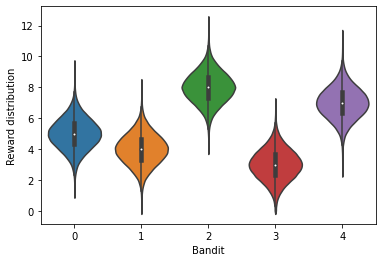

In [37]:
samples = [[bandit.pull() for _ in range(100000)] for bandit in testbed]

plt.figure()
sns.violinplot(data=samples)
plt.xlabel("Bandit")
plt.ylabel("Reward distribution");

## Implementation of a simple greedy algorithm

The bandits are implemented as classes with the following properties:
* mean of the underlying distribution $q$.
* number of previous samplings $n$.
* current estimate of reward $Q$.

The bandits have the following methods:
* init: in the simplest case, we initialize $Q=0$.
* pull: return a value $R$ from the underlying distribution
* update: update the current reward estimate: $Q_t = Q_{t-1} + \frac{1}{n} (R- Q_{t-1})$
* sample: returns the current reward estimate $Q$.

In every step of the bandit problem, we have to *choose an action*. Only for this action, we will receive a reward value.

This is different to other machine learning problems, as we do not receive information on the rewards that we would have received for the other possible actions!

Let us first look at the *greedy algorithm*, i.e. we only exploit, we do not explore.

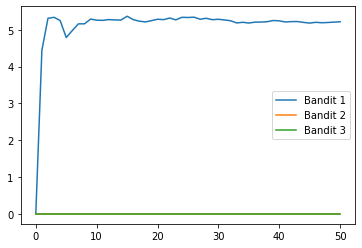

In [24]:
N_TRIALS = 50

rewards = np.ndarray((N_TRIALS +1, len(testbed)))

estimated_rewards = [bandit.sample() for bandit in testbed]
rewards[0, :] = estimated_rewards
for n in range(N_TRIALS):
    bandit = testbed[np.argmax(estimated_rewards)]
    R = bandit.pull()
    bandit.update(R)
    estimated_rewards = [bandit.sample() for bandit in testbed]
    rewards[n + 1, :] = estimated_rewards

plt.figure()
for b in range(rewards.shape[1]):
    plt.plot(rewards[:, b], label=f'Bandit {b+1}')
plt.legend()
plt.show()

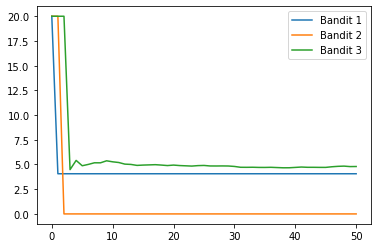

In [27]:
from optimistic_bandit import OptimisticBandit
testbed = [OptimisticBandit(3, Q=20), OptimisticBandit(1, Q=20), OptimisticBandit(5, Q=20)]
N_TRIALS = 50

rewards = np.ndarray((N_TRIALS +1, len(testbed)))

estimated_rewards = [bandit.sample() for bandit in testbed]
rewards[0, :] = estimated_rewards
for n in range(N_TRIALS):
    bandit = testbed[np.argmax(estimated_rewards)]
    R = bandit.pull()
    bandit.update(R)
    estimated_rewards = [bandit.sample() for bandit in testbed]
    rewards[n + 1, :] = estimated_rewards

plt.figure()
for b in range(rewards.shape[1]):
    plt.plot(rewards[:, b], label=f'Bandit {b+1}')
plt.legend()
plt.show()